# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

## The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [83]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
print('shape of data: ',df.shape)

shape of data:  (41188, 21)


In [3]:
pd.set_option('display.max_columns', None)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# check the missing value
missing = df.isnull().sum()
missing_frame = pd.DataFrame(missing)
missing_frame.T.rename(index = {0:'num_missing'})

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
num_missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# examine non numeric data
for col in df.select_dtypes(exclude=['float','int64']).columns:
    print(col,df[col].unique(),'\n')

job ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

marital ['married' 'single' 'divorced' 'unknown'] 

education ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

default ['no' 'unknown' 'yes'] 

housing ['no' 'yes' 'unknown'] 

loan ['no' 'yes' 'unknown'] 

contact ['telephone' 'cellular'] 

month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

day_of_week ['mon' 'tue' 'wed' 'thu' 'fri'] 

poutcome ['nonexistent' 'failure' 'success'] 

y ['no' 'yes'] 



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### The goal is to increase efficiency of directed campaigns for long-term deposit subscriptions by reducing the number of contacts to do. We will determine if a client will subscribe a deposit by his or her characteristics and contact information. We will make an analysis on what attribute influence the the successs rate.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [7]:
df['y']= df['y'].apply(lambda x: 1 if x == 'yes' else 0)
features = df.drop('y',axis = 1)
labels = df['y']
numeric_features = features.select_dtypes(exclude=['object']).columns.values
categorical_features = features.select_dtypes(include='object').columns.values
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop='if_binary'), categorical_features),
    ]
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(features,labels,random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [9]:
# use majority vote to determine the baseline model
majority_vote = labels.value_counts(normalize=True)
majority_vote

0    0.887346
1    0.112654
Name: y, dtype: float64

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [10]:
log_pipe = Pipeline([
    ('preprocessor',preprocessor),
    ('log',LogisticRegression())
])
start = time.time()
log_pipe.fit(X_train,y_train)
stop = time.time()
log_fit_time = stop - start
print(f'The train time of Logistic Regression {log_fit_time}')

The train time of Logistic Regression 0.3602330684661865


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Problem 9: Score the Model

What is the accuracy of your model?

In [11]:
log_train_acc = log_pipe.score(X_train,y_train)
log_test_acc = log_pipe.score(X_test,y_test)
print(f'train_acc {log_train_acc}')
print(f'test_acc {log_test_acc}')

train_acc 0.9113981418536143
test_acc 0.9127901330484607


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [12]:
svc_pipe = Pipeline([
    ('preprocessor',preprocessor),
    ('svc',SVC())
])
start = time.time()
svc_pipe.fit(X_train,y_train)
stop = time.time()
svc_fit_time = stop - start
print(f'The train time of svc {svc_fit_time}')
svc_train_acc = svc_pipe.score(X_train,y_train)
svc_test_acc = svc_pipe.score(X_test,y_test)
print(f'train_acc {svc_train_acc}')
print(f'test_acc {svc_test_acc}')

The train time of svc 18.60211992263794
train_acc 0.9226959308536467
test_acc 0.9127901330484607


In [13]:
knn_pipe = Pipeline([
    ('preprocessor',preprocessor),
    ('knn',knn())
])
start = time.time()
knn_pipe.fit(X_train,y_train)
stop = time.time()
knn_fit_time = stop - start
print(f'The train time of knn {knn_fit_time}')
knn_train_acc = knn_pipe.score(X_train,y_train)
knn_test_acc = knn_pipe.score(X_test,y_test)
print(f'train_acc {knn_train_acc}')
print(f'test_acc {knn_test_acc}')

The train time of knn 0.08324408531188965
train_acc 0.9270985076559516
test_acc 0.903175682237545


In [14]:
dt_pipe = Pipeline([
    ('preprocessor',preprocessor),
    ('dt',DecisionTreeClassifier())
])
start = time.time()
dt_pipe.fit(X_train,y_train)
stop = time.time()
dt_fit_time = stop - start
print(f'The train time of decision tree {dt_fit_time}')
dt_train_acc = dt_pipe.score(X_train,y_train)
dt_test_acc = dt_pipe.score(X_test,y_test)
print(f'train_acc {dt_train_acc}')
print(f'test_acc {dt_test_acc}')


The train time of decision tree 0.23701095581054688
train_acc 1.0
test_acc 0.8862775565698747


In [15]:
model = ['LogisticRegression','SVM','Knn','Decision tree']
train_time = [log_fit_time,svc_fit_time,knn_fit_time,dt_fit_time]
train_acc = [log_train_acc,svc_train_acc,knn_train_acc,dt_train_acc]
test_acc = [log_test_acc,svc_test_acc,knn_test_acc,dt_test_acc]
result = pd.DataFrame({'model':model,'train time':train_time,'train accuracy':train_acc,'test accuracy':test_acc})
result

,model,train time,train accuracy,test accuracy
0,LogisticRegression,0.360233,0.911398,0.912790
1,SVM,18.602120,0.922696,0.912790
2,Knn,0.083244,0.927099,0.903176
3,Decision tree,0.237011,1.000000,0.886278


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [16]:
categorical_features

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'], dtype=object)

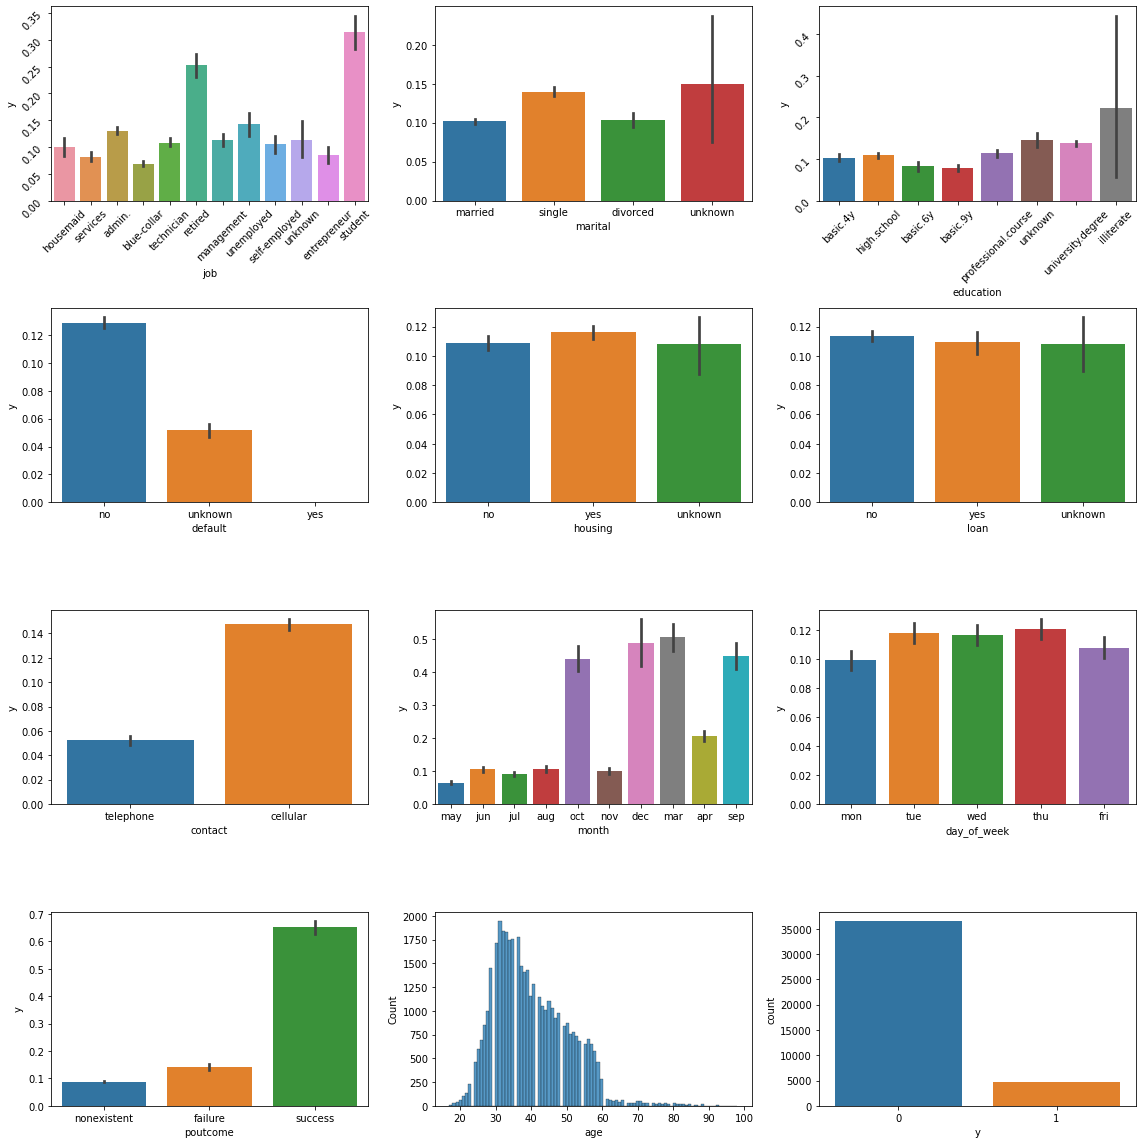

In [17]:
fig, ax = plt.subplots(4, 3, figsize = (16, 16))
sns.barplot(x = 'job', y = 'y',  data = df, ax = ax[0][0])
ax[0][0].tick_params(labelrotation=45)
sns.barplot(x = 'marital', y = 'y',  data = df, ax = ax[0][1])
sns.barplot(x = 'education', y = 'y',  data = df, ax = ax[0][2])
ax[0][2].tick_params(labelrotation=45)
sns.barplot(x = 'default', y = 'y',  data = df, ax = ax[1][0])
sns.barplot(x = 'housing', y = 'y', data = df, ax = ax[1][1])
sns.barplot(x = 'loan', y = 'y',  data = df, ax = ax[1][2])
sns.barplot(x = 'contact', y = 'y',  data = df, ax = ax[2][0])
sns.barplot(x = 'month', y = 'y',  data = df, ax = ax[2][1])
sns.barplot(x = 'day_of_week', y = 'y',  data = df, ax = ax[2][2])
sns.barplot(x = 'poutcome', y = 'y',  data = df, ax = ax[3][0])
sns.histplot(x = 'age',data=df,ax = ax[3][1])
sns.countplot(x='y', data = df, ax = ax[3][2])

plt.tight_layout()


#### From the above figure, we can see the successfull rates for different housing condiitons are nearly the name. Similiarly, same for loan and day of week. In this case, I assume housing condtions,loan and day of week do not influence the successful rate and decide to remove these three features from traning.

In [125]:
new_features = df.drop(['housing','loan','y','day_of_week'], axis=1)
labels = df['y']
X_train,X_test,y_train,y_teset = train_test_split(new_features,labels,random_state=42)

In [126]:
numeric_features = new_features.select_dtypes(exclude=['object']).columns.values
categorical_features = new_features.select_dtypes(include='object').columns.values
new_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop='if_binary'), categorical_features),
    ]
)

In [127]:
# logisitc regression
log_pipe = Pipeline([
    ('preprocessor',new_preprocessor),
    ('log',LogisticRegression(max_iter = 500))
])
log_params = {'log__C':np.logspace(-5,5,10)}
log_grid = GridSearchCV(log_pipe,param_grid=log_params).fit(X_train,y_train)
log_train_acc = log_grid.score(X_train,y_train)
log_test_acc = log_grid.score(X_test,y_test)
print(f'train_acc {log_train_acc}')
print(f'test_acc {log_test_acc}')

train_acc 0.9110096791945874
test_acc 0.9131785957074876


In [92]:
auc_log= roc_auc_score(y_test,log_grid.predict_proba(X_test)[:,1])
auc_log

0.9364637231490903

In [132]:
log_mean_fit = log_grid.cv_results_['mean_fit_time'].min()
log_mean_fit

0.07350220680236816

In [93]:
print(classification_report(y_test,log_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9144
           1       0.68      0.43      0.53      1153

    accuracy                           0.91     10297
   macro avg       0.80      0.70      0.74     10297
weighted avg       0.90      0.91      0.90     10297



In [1]:
# svc
# svm takes forever to run. 
"""svc_pipe = Pipeline([
    ('preprocessor',new_preprocessor),
    ('svc',SVC(max_iter=300))
])
svc_param = {'svc__C': [0.1,1, 10, 100], 'svc__gamma': [1,0.1,0.01,0.001],'svc__kernel': ['rbf', 'poly', 'sigmoid']}
svc_grid = GridSearchCV(svc_pipe,param_grid=svc_param).fit(X_train,y_train)
svc_train_acc = svc_grid.score(X_train,y_train)
svc_test_acc = svc_grid.score(X_test,y_test)
print(f'train_acc {svc_train_acc}')
print(f'test_acc {svc_test_acc}')"""

"svc_pipe = Pipeline([\n    ('preprocessor',new_preprocessor),\n    ('svc',SVC(max_iter=300))\n])\nsvc_param = {'svc__C': [0.1,1, 10, 100], 'svc__gamma': [1,0.1,0.01,0.001],'svc__kernel': ['rbf', 'poly', 'sigmoid']}\nsvc_grid = GridSearchCV(svc_pipe,param_grid=svc_param).fit(X_train,y_train)\nsvc_train_acc = svc_grid.score(X_train,y_train)\nsvc_test_acc = svc_grid.score(X_test,y_test)\nprint(f'train_acc {svc_train_acc}')\nprint(f'test_acc {svc_test_acc}')"

In [94]:
# knn
knn_pipe = Pipeline([
    ('preprocessor',new_preprocessor),
    ('knn',knn())
])

knn_param = {'knn__n_neighbors':list(range(1,15))}

knn_grid = GridSearchCV(knn_pipe, param_grid= knn_param).fit(X_train,y_train)

knn_train_acc = knn_grid.score(X_train,y_train)
knn_test_acc = knn_grid.score(X_test,y_test)
print(f'train_acc {knn_train_acc}')
print(f'test_acc {knn_test_acc}')

train_acc 0.9173869411802791
test_acc 0.907740118481111


In [133]:
knn_mean_fit = knn_grid.cv_results_['mean_fit_time'].mean()
knn_mean_fit

0.0466017620904105

In [96]:
auc_knn = roc_auc_score(y_test,knn_grid.predict_proba(X_test)[:,1])
auc_knn

0.9113343770558602

In [97]:
# decision tree
dt_pipe = Pipeline([
    ('preprocessor',new_preprocessor),
    ('dt',DecisionTreeClassifier())
])

dt_param = tree_para = {'dt__criterion':['gini','entropy'],'dt__max_depth':np.arange(3,20,2)}
dt_grid = GridSearchCV(dt_pipe,param_grid=dt_param).fit(X_train,y_train)
dt_train_acc = dt_grid.score(X_train,y_train)
dt_test_acc = dt_grid.score(X_test,y_test)
print(f'train_acc {dt_train_acc}')
print(f'test_acc {dt_test_acc}')

train_acc 0.9164805283092162
test_acc 0.9159949499854326


In [134]:
dt_mean_fit = dt_grid.cv_results_['mean_fit_time'].mean()
dt_fit_time

0.23701095581054688

In [98]:
auc_dt = roc_auc_score(y_test,dt_grid.predict_proba(X_test)[:,1])
auc_dt

0.9237657630176974

In [135]:
# summarize the result
model = ['LogisticRegression','Knn','Decision tree']
train_acc = [log_train_acc,knn_train_acc,dt_train_acc]
test_acc = [log_test_acc,knn_test_acc,dt_test_acc]
mean_fit = [log_mean_fit,knn_mean_fit,dt_fit_time]
auc = [auc_log,auc_knn,auc_dt]
new_result = pd.DataFrame({'model':model,'train accuracy':train_acc,'test accuracy':test_acc,'auc':auc,'mean fit time':mean_fit})
new_result

,model,train accuracy,test accuracy,auc,mean fit time
0,LogisticRegression,0.911010,0.913179,0.936464,0.073502
1,Knn,0.917387,0.907740,0.911334,0.046602
2,Decision tree,0.916481,0.915995,0.923766,0.237011


In [100]:
# previous result
result

,model,train time,train accuracy,test accuracy
0,LogisticRegression,0.360233,0.911398,0.912790
1,SVM,18.602120,0.922696,0.912790
2,Knn,0.083244,0.927099,0.903176
3,Decision tree,0.237011,1.000000,0.886278


##### Questions

##### Q1: after using column ColumnTransformer, column name disapper. Since there is no name for each feature, how do i analysis feature importance? or how to keep column when using column transfermer?
##### Q2: after using gridserchcv to find the best hyperparameter, the accuracy does not improve. what can i do to improve the accuracy?

### Feature importance

In [139]:
new_features = df.drop(['housing','loan','y','day_of_week'], axis=1)
categorical_features = new_features.select_dtypes(include='object').columns.values
new_features = pd.get_dummies(new_features,categorical_features)
labels = df['y']
X_train,X_test,y_train,y_teset = train_test_split(new_features,labels,random_state=42)

In [140]:
# logisitc regression
log_pipe = Pipeline([
    ('scale',StandardScaler()),
    ('log',LogisticRegression(max_iter = 500))
])
log_params = {'log__C':np.logspace(-5,5,10)}
log_grid = GridSearchCV(log_pipe,param_grid=log_params).fit(X_train,y_train)
log_train_acc = log_grid.score(X_train,y_train)
log_test_acc = log_grid.score(X_test,y_test)
print(f'train_acc {log_train_acc}')
print(f'test_acc {log_test_acc}')
print('best parameter',log_grid.best_params_)

train_acc 0.9110096791945874
test_acc 0.9131785957074876
best parameter {'log__C': 3.593813663804626}


In [141]:
r = permutation_importance(log_grid, X_test, y_test,
                          n_repeats=30,
                         random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
       print(f"{X_train.columns[i]:<8}  "
             f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

emp.var.rate  0.195 +/- 0.003
cons.price.idx  0.045 +/- 0.002
duration  0.038 +/- 0.002
euribor3m  0.013 +/- 0.001
nr.employed  0.006 +/- 0.001
pdays     0.005 +/- 0.000
poutcome_success  0.002 +/- 0.000
month_aug  0.002 +/- 0.001
month_mar  0.002 +/- 0.000
contact_telephone  0.002 +/- 0.001
contact_cellular  0.002 +/- 0.001
cons.conf.idx  0.001 +/- 0.000
month_jun  0.001 +/- 0.000
default_no  0.001 +/- 0.000
default_unknown  0.001 +/- 0.000
month_sep  0.001 +/- 0.000
job_entrepreneur  0.000 +/- 0.000
education_unknown  0.000 +/- 0.000


In [142]:
coef = log_grid.best_estimator_.named_steps.log.coef_[0]
name = X_train.columns.values
df_coef = pd.DataFrame({'feature':name,'coeff':coef})
df_coef = df_coef.sort_values(by = 'coeff',ascending=False)[:5]

<AxesSubplot:xlabel='feature', ylabel='coeff'>

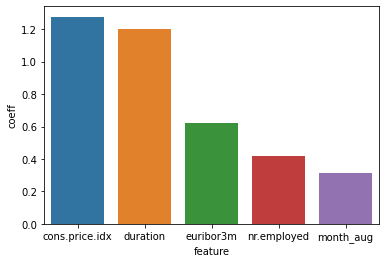

In [143]:
sns.barplot(data = df_coef,x = 'feature',y = 'coeff')